In [1]:
import sys
import lcm
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
## processing utilities
def processMultipleContactsMsg(msg):
    d = dict()
    d['msg'] = msg
    linksInMsg = []
    linksWithForce = []
    d['linksInMsg'] = linksInMsg
    d['linksWithForce'] = linksWithForce
    
    for idx in xrange(0,msg.num_contacts):
        singleMsg = msg.contacts[idx]
        linkName = str(singleMsg.body_name)
        linksInMsg.append(linkName)
        d[linkName] = singleMsg
        force = np.array(singleMsg.contact_force)
        forceMagnitude = np.linalg.norm(force)
        if forceMagnitude > 0.1:
            linksWithForce.append(linkName)
            
    return d


def processActualAndEstimatedMsg(msg):
    d = dict()
    d['actual'] = processMultipleContactsMsg(msg.actual_contact_location)
    d['estimated'] = processMultipleContactsMsg(msg.estimated_contact_location)
    return d


def findLinkWithClosestEstimatedContactPoint(act, est, linkName):
    actPosition = np.array(act[linkName].contact_position_in_world)
    minDist = 1e5 # just make it something really large for now
    estLinkName = None
    
    for key in est['linksInMsg']:
        val = est[key]
        estPosition = np.array(val.contact_position_in_world)
        dist = np.linalg.norm(actPosition - estPosition)
        if (dist < minDist):
            minDist = dist
            estLinkName = key
    
    return estLinkName


# need to be careful here, what if links with force don't match up to
# the estimated ones, which is what happens at beginning of log
def computeErrorFromProcessedMsg(proMsg):
    d = dict()
    est = proMsg['estimated']
    act = proMsg['actual']
    linksWithForce = act['linksWithForce']
    
    numLinksWithForce = len(linksWithForce)
    estNumLinksWithForce = len(est['linksWithForce'])
    
    if numLinksWithForce != estNumLinksWithForce:
        print "estimated and actual don't match"
    
    totalError = 0
    hadLinkMiss = False
    for linkName in linksWithForce:
        actualPosition = np.array(act[linkName].contact_position_in_world)
                    
        # this is typical case
        estLinkName = None
        # check if this is in the list of links for estMessage
        if linkName in est.keys():
            estLinkName = linkName
        else:
            estLinkName = findLinkWithClosestEstimatedContactPoint(act, est, linkName)



        estPosition = np.array(est[estLinkName].contact_position_in_world)

        deltaPosition = actualPosition - estPosition
        error = np.linalg.norm(deltaPosition)
        d[linkName] = error

        totalError += error
        
        
    
        
    avgError = totalError/numLinksWithForce
    d['avgError'] = avgError
    d['totalError'] = totalError
    d['numLinksWithForce'] = numLinksWithForce
    
    proMsg['errorStats'] = d
    
    return proMsg


def computeErrorFromProcessedMsgTwoStepMethod(proMsg):
    d = dict()
    est = proMsg['estimated']
    act = proMsg['actual']
    linksWithForce = act['linksWithForce']
    
    numLinksWithForce = len(linksWithForce)
    totalError = 0
    hadLinkMiss = False
    for linkName in linksWithForce:
        actualPosition = np.array(act[linkName].contact_position_in_world)
                    
        # this is typical case
        estLinkName = linkName
        linkMsg = est[linkName]
        missedLink = linkMsg.utime < 0

        estPosition = np.array(est[linkName].contact_position_in_world)
        deltaPosition = actualPosition - estPosition
        error = np.linalg.norm(deltaPosition)
        
        if missedLink:
            d[linkName] = -100
            hadLinkMiss = True
        else:
            d[linkName] = error
        
        totalError += error
        
        
    
        
    avgError = totalError/numLinksWithForce
    d['avgError'] = avgError
    d['totalError'] = totalError
    d['numLinksWithForce'] = numLinksWithForce
    d['hadLinkMiss'] = hadLinkMiss
    if hadLinkMiss:
        d['avgError'] = -100
        d['totalError'] = -100
    
    proMsg['errorStats'] = d
    
    return proMsg

    
## Log loading utilities
def loadLog(logName='test', numberOfSecondsToSkip=None):
    
    if numberOfSecondsToSkip is None:
        numberOfSecondsToSkip = 3
        
        
    logData = dict()
    pathToLogs = "/media/manuelli/DATA/logs/CASE/"
    logFullFilepath = pathToLogs + logName
    log = lcm.EventLog(logFullFilepath, "r")
    
    channelsToDecode = dict()

    
    channelData = dict()
    channelData['channelName'] = "ACTUAL_AND_ESTIMATED_CONTACT_LOCATIONS"
    channelData['msgType'] = 'actual_and_estimated_contact_locations_t'
    channelData['msgModule'] = 'drc'

    channelsToDecode[channelData['channelName']] = channelData
    
    
    channelData = dict()
    channelData['channelName'] = "TWO_STEP_ESTIMATOR"
    channelData['msgType'] = 'actual_and_estimated_contact_locations_t'
    channelData['msgModule'] = 'drc'
    channelsToDecode[channelData['channelName']] = channelData


    listOfChannels = channelsToDecode.keys()

    for name, data in channelsToDecode.iteritems():
        module = __import__(data['msgModule'])
        msgClass = getattr(module, data['msgType'])
        data['times'] = []
        data['msgs'] = []
        data['msgClass'] = msgClass
        
    firstTime = None 
    # run through all events in log, pick out the ones we want
    for event in log:
        if event.channel in listOfChannels:
            data = channelsToDecode[event.channel]
            msg = data['msgClass'].decode(event.data)

            # test if it has timestamp or utime
            if hasattr(msg,'utime'):
                time = msg.utime*1.0/1e6
            else:
                time = msg.timestamp*1.0/1e6
                
            if firstTime is None and event.channel == "ACTUAL_AND_ESTIMATED_CONTACT_LOCATIONS":
                firstTime = time
            
                
            if firstTime is None:
                continue
                
            # remove the first bit of each log
            if time - firstTime < numberOfSecondsToSkip:
                continue

            data['times'].append(time)
            data['msgs'].append(msg)
            
    return channelsToDecode


def processLoadedLog(logData):
    for channelName, data in logData.iteritems():
        data['proMsgs'] = []
        data['times'] = np.array(data['times'])
        
        data['numTimes'] = np.size(data['times'])
        
        for idx in xrange(0,data['numTimes']):
#             print "idx ", idx
            msg = data['msgs'][idx]
            proMsg = processActualAndEstimatedMsg(msg)
            data['proMsgs'].append(proMsg)
            
    return logData


def computeErrorsOnLog(logData, channelName='ACTUAL_AND_ESTIMATED_CONTACT_LOCATIONS'):
    d = logData[channelName]
    for proMsg in d['proMsgs']:
        computeErrorFromProcessedMsg(proMsg)
        
def computeTwoStepErrorsOnLog(logData):
    d = logData['TWO_STEP_ESTIMATOR']
    for proMsg in d['proMsgs']:
        computeErrorFromProcessedMsgTwoStepMethod(proMsg)
            
            
def loadAndProcessLog(logName, timeToSkip):
    logData = loadLog(logName, numberOfSecondsToSkip=timeToSkip)
    processLoadedLog(logData)
    computeErrorsOnLog(logData, channelName='ACTUAL_AND_ESTIMATED_CONTACT_LOCATIONS')
    computeTwoStepErrorsOnLog(logData)
    return logData


def getAverageErrorFromCPF(logData):
    d = logData['ACTUAL_AND_ESTIMATED_CONTACT_LOCATIONS']
    times = d['times']
    numTimes = d['numTimes']

    # make error into numpy array so we can plot it
    avgErrorArray = []
    for idx in xrange(0,numTimes):
        proMsg = d['proMsgs'][idx]
        avgErrorArray.append(proMsg['errorStats']['avgError'])

    avgErrorArray = np.array(avgErrorArray)
    
    
    returnData = dict()
    returnData['avgErrorArray'] = avgErrorArray
    returnData['avgError'] = np.mean(avgErrorArray)
    returnData['times'] = times
    returnData['shiftedTimes'] = times-times[0]
    
    return returnData


def getAverageErrorFromTwoStep(logData):
    d = logData['TWO_STEP_ESTIMATOR']
    times = d['times']
    numTimes = d['numTimes']
    
    # make error into numpy array so we can plot it
    avgErrorArray = []
    for idx in xrange(0,numTimes):
        proMsg = d['proMsgs'][idx]
        avgErrorArray.append(proMsg['errorStats']['avgError'])

    avgErrorArray = np.array(avgErrorArray)
    
    linkMissIdx = np.where(avgErrorArray < 0)
    linkHitIdx = np.where(avgError>=0)
    
    
    avgErrorArrayHit = avgErrorArray[linkHitIdx]
    
    returnData = dict()
    returnData['avgErrorArray'] = avgErrorArray
    returnData['avgErrorHit'] = np.mean(avgErrorArrayHit)
    returnData['times'] = times
    returnData['shiftedTimes'] = times-times[0]
    returnData['missFraction'] = np.size(linkMissIdx)*1.0/numTimes
    returnData['hitFraction'] = 1 - returnData['missFraction']
    
    
    returnData['hitTimes'] = returnData['shiftedTimes'][linkHitIdx]
    returnData['missTimes'] = returnData['shiftedTimes'][linkMissIdx]
    
    return returnData
    
    
# no noise logs
def getErrorDataFromLogs(logNamePrefix="singleContactForces_single_", logNameSuffix = "_no_noise", numRuns=7, runList=None,
                        timeToSkip=None):
#     logNamePrefix = "singleContactForces_single_"
#     logNameSuffix = "_no_noise"
    cpfError = dict()
    twoStepError = dict()
    
    
    if runList is None:
        runList = range(1,numRuns + 1)
    
    for idx in runList:
        logName = logNamePrefix + str(idx) + logNameSuffix
        print logName
        logData = loadAndProcessLog(logName, timeToSkip)
        errorData = getAverageErrorFromCPF(logData)
        cpfError[idx] = errorData
#         twoStepError[idx] = getAverageErrorFromTwoStep(logData)

    # make a bar chart with the data
    avgError = []
    for idx, data in cpfError.iteritems():
        avgError.append(data['avgError'])
        
    returnData = dict()
    returnData['cpfError'] = cpfError
    
    avgErrorArray = getAsNumpyArray(cpfError,'avgError')
    returnData['avgError'] = np.mean(avgErrorArray)
    returnData['stdDev'] = np.std(avgErrorArray)
#     returnData['twoStepError'] = twoStepError
    
    return returnData

def getAsNumpyArray(d, key):
    l = []
    for _, data in d.iteritems():
        l.append(data[key])
    
    return np.array(l)

In [4]:
runList = [1,2,3,4]
err2 = dict()
err2[0] = getErrorDataFromLogs(logNamePrefix="doubleContactForces_double_", logNameSuffix = "_no_noise", runList=runList)

err3 = dict()
runList = [1,2,3]
err3[0] = getErrorDataFromLogs(logNamePrefix='tripleContactForces_triple_', logNameSuffix = "_no_noise", runList=runList,
                              timeToSkip=2.0)
# err3[1] = getErrorDataFromLogs(logNamePrefix='tripleContactForces_triple_', logNameSuffix = "_noise_01", runList=runList)
# err3[2] = getErrorDataFromLogs(logNamePrefix='tripleContactForces_triple_', logNameSuffix = "_noise_02", runList=runList)

doubleContactForces_double_1_no_noise
doubleContactForces_double_2_no_noise
doubleContactForces_double_3_no_noise
doubleContactForces_double_4_no_noise
tripleContactForces_triple_1_no_noise
tripleContactForces_triple_2_no_noise
tripleContactForces_triple_3_no_noise


In [6]:
err1 = dict()
runList = [1,2,3,4,5,6,7]
err1[0] = getErrorDataFromLogs(logNamePrefix="singleContactForces_single_", logNameSuffix = "_no_noise", numRuns=7, runList=runList)
err1[1] = getErrorDataFromLogs(logNamePrefix="singleContactForces_single_", logNameSuffix = "_noise_01", numRuns=7, runList=runList)
err1[2] = getErrorDataFromLogs(logNamePrefix="singleContactForces_single_", logNameSuffix = "_noise_02", numRuns=7, runList=runList)

singleContactForces_single_1_no_noise
singleContactForces_single_2_no_noise
singleContactForces_single_3_no_noise
singleContactForces_single_4_no_noise
singleContactForces_single_5_no_noise
singleContactForces_single_6_no_noise
singleContactForces_single_7_no_noise
singleContactForces_single_1_noise_01
singleContactForces_single_2_noise_01
singleContactForces_single_3_noise_01
singleContactForces_single_4_noise_01
singleContactForces_single_5_noise_01
singleContactForces_single_6_noise_01
singleContactForces_single_7_noise_01
singleContactForces_single_1_noise_02
singleContactForces_single_2_noise_02
singleContactForces_single_3_noise_02
singleContactForces_single_4_noise_02
singleContactForces_single_5_noise_02
singleContactForces_single_6_noise_02
singleContactForces_single_7_noise_02


In [7]:
err2 = dict()
runList = [1,2,3,4]
err2[0] = getErrorDataFromLogs(logNamePrefix="doubleContactForces_double_", logNameSuffix = "_no_noise", runList=runList)
err2[1] = getErrorDataFromLogs(logNamePrefix="doubleContactForces_double_", logNameSuffix = "_noise_01", runList=runList)
err2[2] = getErrorDataFromLogs(logNamePrefix="doubleContactForces_double_", logNameSuffix = "_noise_02", runList=runList)

doubleContactForces_double_1_no_noise
doubleContactForces_double_2_no_noise
doubleContactForces_double_3_no_noise
doubleContactForces_double_4_no_noise
doubleContactForces_double_1_noise_01
doubleContactForces_double_2_noise_01
doubleContactForces_double_3_noise_01
doubleContactForces_double_4_noise_01
doubleContactForces_double_1_noise_02
doubleContactForces_double_2_noise_02
doubleContactForces_double_3_noise_02
doubleContactForces_double_4_noise_02


In [17]:
err3 = dict()
runList = [1,2,3]
err3[0] = getErrorDataFromLogs(logNamePrefix='tripleContactForces_triple_', logNameSuffix = "_no_noise", runList=runList)
err3[1] = getErrorDataFromLogs(logNamePrefix='tripleContactForces_triple_', logNameSuffix = "_noise_01", runList=runList)
err3[2] = getErrorDataFromLogs(logNamePrefix='tripleContactForces_triple_', logNameSuffix = "_noise_02", runList=runList)

tripleContactForces_triple_1_no_noise
tripleContactForces_triple_2_no_noise
tripleContactForces_triple_3_no_noise
tripleContactForces_triple_1_noise_01
tripleContactForces_triple_2_noise_01
tripleContactForces_triple_3_noise_01
tripleContactForces_triple_1_noise_02
tripleContactForces_triple_2_noise_02
tripleContactForces_triple_3_noise_02


[ 0.41666667  1.41666667  2.41666667]


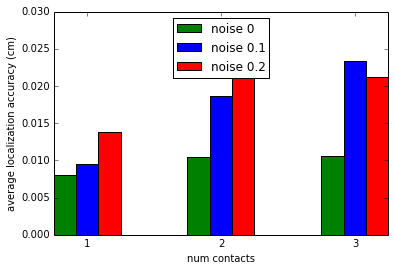

In [18]:
# do the plotting
width = 0.5/3
N = 3

err = [err1,err2,err3]
fig, ax = plt.subplots()

for idx in xrange(0,N):
    errDict = err[idx]
    rects1 = ax.bar(idx, errDict[0]['avgError'], width, color='g')
    rects2 = ax.bar(idx + width, errDict[1]['avgError'], width, color='b')
    rects3 = ax.bar(idx + 2 * width, errDict[2]['avgError'], width, color='r')

    
ax.legend((rects1[0],rects2[0],rects3[0]), ('noise 0', 'noise 0.1', 'noise 0.2'), loc='upper center')

# ind = np.arange(0,N)
# errorDicts = [errorData, errorData_01, errorData_02]
# fig, ax = plt.subplots()

# numContacts = 1
# rects1 = ax.bar(numContacts, errorDicts[idx], width, color='r')

# rects1 = ax.bar(ind, errorDicts, width, color='r')
# rects2 = ax.bar(ind + width, tsAvgError*100, width, color='g')
# rects2 = ax.bar(ind + 2*width, tsAvgError*100, width, color='b')


ax.set_ylabel('average localization accuracy (cm)')
ax.set_xlabel('num contacts')
labelTicks = np.array([0,1,2]) + width*3/2.0
print labelTicks + width
ax.set_xticks(labelTicks)
ax.set_xticklabels(('1','2', '3'))

[0.0080984422681686114, 0.010398878610696528, 0.010594986261212287]
[ 0.41666667  1.41666667  2.41666667]


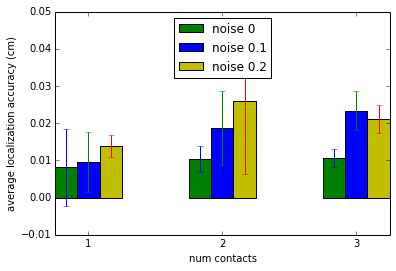

In [19]:
# do the plotting
width = 0.5/3
N = 3

plt.clf()
plt.figure()
err = [err1,err2,err3]
fig, ax = plt.subplots()

# for idx in xrange(0,N):
#     errDict = err[idx]
#     rects1 = ax.bar(idx, errDict[0]['avgError'], width, color='g')
#     rects2 = ax.bar(idx + width, errDict[1]['avgError'], width, color='b')
#     rects3 = ax.bar(idx + 2 * width, errDict[2]['avgError'], width, color='r')

    
e = dict()
sd = dict()

for varIdx in xrange(0,3):
    e[varIdx] = []
    sd[varIdx] = []
    for idx in xrange(0,3):
        errDict = err[idx]
        e[varIdx].append(errDict[varIdx]['avgError'])
        sd[varIdx].append(errDict[varIdx]['stdDev'])
    
    
print e[0]
# ax.legend((rects1[0],rects2[0],rects3[0]), ('noise 0', 'noise 0.1', 'noise 0.2'), loc='upper center')

# # ind = np.arange(0,N)
# # errorDicts = [errorData, errorData_01, errorData_02]
# # fig, ax = plt.subplots()

# # numContacts = 1
# # rects1 = ax.bar(numContacts, errorDicts[idx], width, color='r')

# # rects1 = ax.bar(ind, errorDicts, width, color='r')
# # rects2 = ax.bar(ind + width, tsAvgError*100, width, color='g')
# # rects2 = ax.bar(ind + 2*width, tsAvgError*100, width, color='b')
ind = np.arange(0,3)
colors = ['g','b','y']
rects = []
for idx in xrange(0,3):
    rects.append(ax.bar(ind + width*idx, e[idx], width,color=colors[idx],yerr=sd[idx])[0])

ax.set_ylabel('average localization accuracy (cm)')
ax.set_xlabel('num contacts')
labelTicks = np.array([0,1,2]) + width*3/2.0
print labelTicks + width
ax.set_xticks(labelTicks)
ax.set_xticklabels(('1','2', '3'))
ax.legend(rects, ('noise 0', 'noise 0.1', 'noise 0.2'), loc='upper center')


In [ ]:
err1[0]['stdDev']

In [ ]:
# make bar plot
width = 0.5/3
N = 1
ind = np.arange(0,N)
errorDicts = [errorData, errorData_01, errorData_02]
fig, ax = plt.subplots()

numContacts = 1

rects1 = ax.bar(ind, errorDicts, width, color='r')
rects2 = ax.bar(ind + width, tsAvgError*100, width, color='g')
rects2 = ax.bar(ind + 2*width, tsAvgError*100, width, color='b')


ax.set_ylabel('average localization accuracy (cm)')
ax.set_xlabel('num contacts')
ax.set_xticks(ind + width)
# ax.set_xticklabels(('1','2', '3'))

In [16]:
numContacts = 3
noiseLevel = 1
a = getAsNumpyArray(err[numContacts-1][noiseLevel]['cpfError'],'avgError')
print a

[ 0.01527454  0.01564694  0.14191326]


In [25]:
0.123+0.272
0.067+0.177
print "1 contact", 0.115+0.046

1 contact 0.161


In [29]:
print 50/395.0
print 25/244.0
print 18/161.0

0.126582278481
0.102459016393
0.111801242236


In [32]:
50**3/(50*3)

833